OUTCOME
Blue     4038
Red      4019
NC/NC      81
D/D        59
Name: count, dtype: int64
OUTCOME
Red     4019
Blue    4019
Name: count, dtype: int64
Accuracy: 0.6032
Classification Report:
              precision    recall  f1-score   support

         Red       0.60      0.60      0.60       801
        Blue       0.60      0.60      0.60       807

    accuracy                           0.60      1608
   macro avg       0.60      0.60      0.60      1608
weighted avg       0.60      0.60      0.60      1608

Original Prediction: 🏆 Dustin Poirier with confidence 68.82%
Swapped Prediction:  🏆 Max Holloway with confidence 54.48%
Final Swap-Averaged Prediction: 🏆 Dustin Poirier with confidence 57.17%
Swap-Averaged Model Accuracy: 0.6219
Swap-Averaged Prediction: 🏆 Dustin Poirier with confidence 57.17%


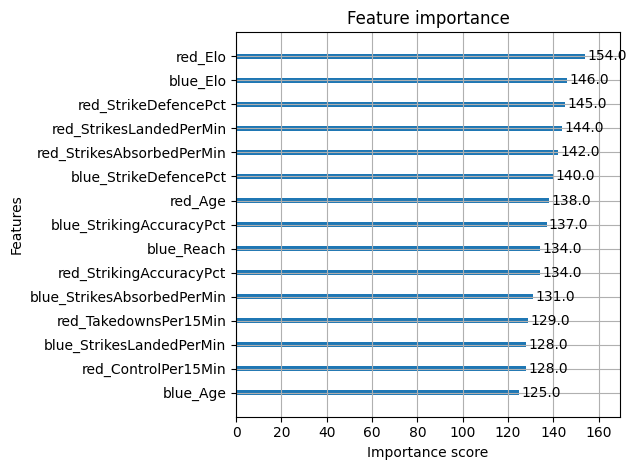

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import create_fight


# Load data
df = pd.read_csv("../processed_data/fight_results_.csv")

fighters_df=pd.read_csv("../processed_data/fighter_averages.csv")


fighters_df["DOB"] = pd.to_datetime(fighters_df["DOB"], errors='coerce')
today = pd.Timestamp.today()
fighters_df["Age"] = fighters_df["DOB"].apply(lambda dob: (today - dob).days // 365 if pd.notnull(dob) else np.nan)

# Drop unsupported columns
#print(df.columns.tolist())

from sklearn.utils import resample

print(df["OUTCOME"].value_counts())

red_wins = df[df["OUTCOME"] == "Red"]
blue_wins = df[df["OUTCOME"] == "Blue"]

min_len = min(len(red_wins), len(blue_wins))



df = pd.concat([
   red_wins.sample(min_len, random_state=42),
   blue_wins.sample(min_len, random_state=42)
])



print(df["OUTCOME"].value_counts())

df.columns = df.columns.str.strip()

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['red_DOB'] = pd.to_datetime(df['red_DOB'], errors='coerce')
df['blue_DOB'] = pd.to_datetime(df['blue_DOB'], errors='coerce')

# Calculate ages at fight date (in years)
df['red_Age'] = (df['DATE'] - df['red_DOB']).dt.days // 365
df['blue_Age'] = (df['DATE'] - df['blue_DOB']).dt.days // 365

df = df.drop(columns=["DATE", "red_DOB", "blue_DOB"])



# Convert to category dtype
categorical_cols = ["METHOD", "red_Stance", "blue_Stance", "red_Name", "blue_Name"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Filter target and encode
df = df[df["OUTCOME"].isin(["Red", "Blue"])].copy()
df["OUTCOME"] = df["OUTCOME"].map({"Red": 0, "Blue": 1})


# Features and target
X = df.drop(columns=["OUTCOME", "METHOD", "red_Name", "blue_Name",], axis=1) # "red_Name", "blue_Name", "red_Elo", "blue_Elo"
y = df["OUTCOME"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Train XGBoost with native categorical support
model = XGBClassifier(
    
    eval_metric="logloss",
    enable_categorical=True,
    n_estimators=500,     # fewer trees
    max_depth=3,          # shallower trees
    learning_rate=0.1,    # slightly faster learning
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=1,
    reg_lambda=1
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Red", "Blue"]))



# Plot importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=15)
plt.tight_layout()
#plt.show()



def create_features_from_df(fighter1_name, fighter2_name, df):
    red_stats = df[df["Name"] == fighter1_name]
    blue_stats = df[df["Name"] == fighter2_name]

    if red_stats.empty or blue_stats.empty:
        raise ValueError("One or both fighter names not found in the dataframe.")

    # Drop the 'Name' column to keep only features
    red_features = red_stats.drop(columns=["Name"]).iloc[0]
    blue_features = blue_stats.drop(columns=["Name"]).iloc[0]

    # Prefix features
    red_features.index = ["red_" + str(col) for col in red_features.index]
    blue_features.index = ["blue_" + str(col) for col in blue_features.index]

    # Combine into one feature vector
    combined_features = pd.concat([red_features, blue_features])

    # Convert to DataFrame with one row
    return combined_features.to_frame().T


# Fight Prediction
fighter_2 = "Max Holloway"
fighter_1 = "Dustin Poirier"

#original_X, swapped_X = create_fight(fighter_1, fighter_2, fighters_df)
def create_features_from_df(f1, f2, df):
    red = df[df["Name"] == f1].drop(columns=["Name", "DOB"], errors='ignore').iloc[0]
    blue = df[df["Name"] == f2].drop(columns=["Name", "DOB"], errors='ignore').iloc[0]
    red.index = ["red_" + col for col in red.index]
    blue.index = ["blue_" + col for col in blue.index]
    return pd.concat([red, blue]).to_frame().T


original_X = create_features_from_df(fighter_1, fighter_2, fighters_df)
swapped_X = create_features_from_df(fighter_2, fighter_1, fighters_df)
numeric_cols = [
    'red_StrikesLandedPerMin', 'red_StrikesAbsorbedPerMin', 'red_TakedownsPer15Min', 'red_SubmissionsPer15Min',
    'red_ControlPer15Min', 'red_StrikingAccuracyPct', 'red_StrikeDefencePct', 'red_TakedownAccuracyPct', 'red_TakedownDefencePct',
    'blue_StrikesLandedPerMin', 'blue_StrikesAbsorbedPerMin', 'blue_TakedownsPer15Min', 'blue_SubmissionsPer15Min',
    'blue_ControlPer15Min', 'blue_StrikingAccuracyPct', 'blue_StrikeDefencePct', 'blue_TakedownAccuracyPct', 'blue_TakedownDefencePct',
    'red_OpponentTakedownsPer15Min', 'blue_OpponentTakedownsPer15Min',
    'red_Height', 'red_Weight', 'red_Reach', 'blue_Height', 'blue_Weight', 'blue_Reach', 'red_Elo', 'blue_Elo', 'red_Age', 'blue_Age']

for col in numeric_cols:
    if col in original_X.columns:
        original_X[col] = pd.to_numeric(original_X[col], errors='coerce')
        swapped_X[col] = pd.to_numeric(swapped_X[col], errors='coerce')

categorical_cols = ["red_Stance", "blue_Stance"]
for col in categorical_cols:
    original_X[col] = original_X[col].astype("category")
    swapped_X[col] = swapped_X[col].astype("category")


# # ---------------------------
# # Align feature columns with model
# # ---------------------------
original_X = original_X.reindex(columns=model.feature_names_in_, fill_value=0)
swapped_X  = swapped_X.reindex(columns=model.feature_names_in_, fill_value=0)

# ---------------------------
# Make predictions
# ---------------------------
# Original fight
orig_probs = model.predict_proba(original_X)[0]   # [prob_red_wins, prob_blue_wins]

# Swapped fight
swap_probs = model.predict_proba(swapped_X)[0]    # [prob_red_wins (swapped), prob_blue_wins (swapped)]
swap_probs_corrected = [swap_probs[1], swap_probs[0]]  # flip to align with original

# ---------------------------
# Swap averaging
# ---------------------------
final_probs = [(o + s) / 2 for o, s in zip(orig_probs, swap_probs_corrected)]
final_winner = fighter_1 if final_probs[0] > final_probs[1] else fighter_2
final_confidence = max(final_probs)

# ---------------------------
# Print results
# ---------------------------
print(f"Original Prediction: 🏆 {fighter_1 if orig_probs[0] > orig_probs[1] else fighter_2} "
      f"with confidence {max(orig_probs):.2%}")
print(f"Swapped Prediction:  🏆 {fighter_1 if swap_probs_corrected[0] > swap_probs_corrected[1] else fighter_2} "
      f"with confidence {max(swap_probs_corrected):.2%}")
print(f"Final Swap-Averaged Prediction: 🏆 {final_winner} with confidence {final_confidence:.2%}")

import numpy as np
import pandas as pd

def swap_averaged_prediction(model, X_orig, X_swapped, fighters=None):
    """
    Returns swap-averaged predictions for a single fight or a dataset.

    Parameters:
    - model: trained XGBClassifier
    - X_orig: original feature(s) (DataFrame)
    - X_swapped: swapped feature(s) (DataFrame)
    - fighters: tuple/list of fighter names (fighter_1, fighter_2) for single fight output

    Returns:
    - final_probs: averaged probabilities
    - final_pred: predicted winner label (fighter_1/fighter_2) if single fight
    """

    # Predict probabilities
    orig_probs = model.predict_proba(X_orig)
    swap_probs = model.predict_proba(X_swapped)

    # Flip swapped columns to align with original
    swap_probs_corrected = swap_probs[:, [1,0]]

    # Average
    final_probs = (orig_probs + swap_probs_corrected) / 2

    # Single fight
    if fighters is not None and final_probs.shape[0] == 1:
        fighter_1, fighter_2 = fighters
        final_pred = fighter_1 if final_probs[0][0] > final_probs[0][1] else fighter_2
        return final_probs[0], final_pred

    # Dataset (multiple rows)
    y_pred_final = np.argmax(final_probs, axis=1)
    return final_probs, y_pred_final


# Suppose X_test is the original test set
# Swap red and blue features
X_test_swapped = X_test.copy()
for col in X_test.columns:
    if col.startswith("red_"):
        blue_col = col.replace("red_", "blue_")
        X_test_swapped[col] = X_test[blue_col]
    elif col.startswith("blue_"):
        red_col = col.replace("blue_", "red_")
        X_test_swapped[col] = X_test[red_col]



# Suppose X_test and X_test_swapped are aligned datasets
final_probs, y_pred_final = swap_averaged_prediction(model, X_test, X_test_swapped)


# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Swap-Averaged Model Accuracy: {accuracy:.4f}")


final_probs, final_winner = swap_averaged_prediction(
    model, original_X, swapped_X, fighters=(fighter_1, fighter_2)
)
# final_probs shape: (1, 2)
print(f"Swap-Averaged Prediction: 🏆 {final_winner} with confidence {final_confidence:.2%}")






## Imports

In [88]:
import os
import sys
import optuna
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Add parent directory to path
sys.path.append(os.path.abspath(".."))
from utils import create_fight

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)

# Boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Data Loading and Preperation

In [ ]:
df = pd.read_csv("../processed_data/fight_results_.csv")

fighters_df=pd.read_csv("../processed_data/fighter_averages.csv")


fighters_df["DOB"] = pd.to_datetime(fighters_df["DOB"], errors='coerce')
today = pd.Timestamp.today()
fighters_df["Age"] = fighters_df["DOB"].apply(lambda dob: (today - dob).days // 365 if pd.notnull(dob) else np.nan)

# Drop unsupported columns
#print(df.columns.tolist())

from sklearn.utils import resample

print(df["OUTCOME"].value_counts())

red_wins = df[df["OUTCOME"] == "Red"]
blue_wins = df[df["OUTCOME"] == "Blue"]

min_len = min(len(red_wins), len(blue_wins))



# df = pd.concat([
#    red_wins.sample(min_len, random_state=42),
#    blue_wins.sample(min_len, random_state=42)
# ])

OUTCOME
Blue     4038
Red      4019
NC/NC      81
D/D        59
Name: count, dtype: int64


## Data Cleaning

In [156]:
df.columns = df.columns.str.strip()

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['red_DOB'] = pd.to_datetime(df['red_DOB'], errors='coerce')
df['blue_DOB'] = pd.to_datetime(df['blue_DOB'], errors='coerce')

# Calculate ages at fight date (in years)
df['red_Age'] = (df['DATE'] - df['red_DOB']).dt.days // 365
df['blue_Age'] = (df['DATE'] - df['blue_DOB']).dt.days // 365

df = df.drop(columns=["DATE", "red_DOB", "blue_DOB"])

# Filter target and encode
df = df[df["OUTCOME"].isin(["Red", "Blue"])].copy()
df["OUTCOME"] = df["OUTCOME"].map({"Red": 0, "Blue": 1})

## Train-Test Split and Model Definitions

In [217]:
X = df.drop(columns=["OUTCOME", "METHOD", "red_Name", "blue_Name",], axis=1) # "red_Name", "blue_Name", "red_Elo", "blue_Elo"
y = df["OUTCOME"]

categorical_cols = ["red_Stance", "blue_Stance"]

# One-hot encode all categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

models = {
    #"LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42),
    #"ExtraTrees": ExtraTreesClassifier(n_estimators=300, max_depth=6, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=300, max_depth=6, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "LightGBM": LGBMClassifier( verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Assuming you have X_train, X_test, y_train, y_test
X_train.to_csv("../processed_data/X_train.csv", index=False)
X_test.to_csv("../processed_data/X_test.csv", index=False)
y_train.to_csv("../processed_data/y_train.csv", index=False)
y_test.to_csv("../processed_data/y_test.csv", index=False)


## Optuna Objectives

In [108]:
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "eval_metric": "logloss",
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "verbose": 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

# Optional: add objectives for RandomForest, GradientBoosting, ExtraTrees, HistGradientBoosting
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": 42
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

def objective_hgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 100),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 10.0, log=True),
        "max_bins": trial.suggest_int("max_bins", 128, 255),
        "random_state": 42
    }
    model = HistGradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

## Optuna Studies

In [109]:
studies = {}

for name, func in [("XGBoost", objective_xgb),
                   ("LightGBM", objective_lgb),
                   ("CatBoost", objective_cat),
                   ("HistGradientBoosting", objective_hgb),
                   ("RandomForest", objective_rf)]:
    study = optuna.create_study(direction="maximize")
    study.optimize(func, n_trials=30)
    studies[name] = study
    print(f"{name} best accuracy: {study.best_value:.4f}")

[I 2025-08-21 13:40:34,699] A new study created in memory with name: no-name-c1d58019-45ed-40e4-a325-86bd66210362
[I 2025-08-21 13:40:35,310] Trial 0 finished with value: 0.6172622799441895 and parameters: {'n_estimators': 146, 'max_depth': 4, 'learning_rate': 0.21688177619927249, 'subsample': 0.6669369130634857, 'colsample_bytree': 0.5790101060474389, 'gamma': 3.925778673671321, 'reg_alpha': 4.3131324316483735, 'reg_lambda': 0.8759339288408063}. Best is trial 0 with value: 0.6172622799441895.
[I 2025-08-21 13:40:37,392] Trial 1 finished with value: 0.6043539157920151 and parameters: {'n_estimators': 432, 'max_depth': 6, 'learning_rate': 0.07720912252471819, 'subsample': 0.5189011711975253, 'colsample_bytree': 0.5824497537905751, 'gamma': 0.9841411812809164, 'reg_alpha': 3.0342238172299445, 'reg_lambda': 0.24341569990392997}. Best is trial 0 with value: 0.6172622799441895.
[I 2025-08-21 13:40:38,240] Trial 2 finished with value: 0.6245729762294454 and parameters: {'n_estimators': 320, 

XGBoost best accuracy: 0.6261


[I 2025-08-21 13:41:12,225] Trial 0 finished with value: 0.6111978314215205 and parameters: {'n_estimators': 122, 'max_depth': 9, 'learning_rate': 0.15319981333001426, 'num_leaves': 37, 'subsample': 0.8621457163538111, 'colsample_bytree': 0.7662800474947046}. Best is trial 0 with value: 0.6111978314215205.
[I 2025-08-21 13:41:15,633] Trial 1 finished with value: 0.6093299107588516 and parameters: {'n_estimators': 426, 'max_depth': 11, 'learning_rate': 0.0531820203379875, 'num_leaves': 132, 'subsample': 0.7301060448356295, 'colsample_bytree': 0.5811287000687073}. Best is trial 0 with value: 0.6111978314215205.
[I 2025-08-21 13:41:16,477] Trial 2 finished with value: 0.6135295582284563 and parameters: {'n_estimators': 212, 'max_depth': 6, 'learning_rate': 0.07414142400306167, 'num_leaves': 98, 'subsample': 0.9097274034559271, 'colsample_bytree': 0.973723668818888}. Best is trial 2 with value: 0.6135295582284563.
[I 2025-08-21 13:41:17,738] Trial 3 finished with value: 0.6132175972679764 

LightGBM best accuracy: 0.6258


[I 2025-08-21 13:41:47,210] Trial 0 finished with value: 0.6231724891640723 and parameters: {'iterations': 300, 'depth': 8, 'learning_rate': 0.021096697430421744, 'l2_leaf_reg': 2.2251656307923593}. Best is trial 0 with value: 0.6231724891640723.
C:\Users\craig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\craig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pa

CatBoost best accuracy: 0.6313


[I 2025-08-21 13:45:17,951] Trial 0 finished with value: 0.6219289257167266 and parameters: {'learning_rate': 0.01793771813522481, 'max_iter': 317, 'max_depth': 10, 'min_samples_leaf': 88, 'l2_regularization': 0.5981095440208758, 'max_bins': 157}. Best is trial 0 with value: 0.6219289257167266.
[I 2025-08-21 13:45:19,542] Trial 1 finished with value: 0.6118186337328755 and parameters: {'learning_rate': 0.10712617775507638, 'max_iter': 479, 'max_depth': 4, 'min_samples_leaf': 100, 'l2_regularization': 0.0001921990138778336, 'max_bins': 151}. Best is trial 0 with value: 0.6219289257167266.
[I 2025-08-21 13:45:21,066] Trial 2 finished with value: 0.6073064449103062 and parameters: {'learning_rate': 0.27075116194933857, 'max_iter': 146, 'max_depth': 11, 'min_samples_leaf': 25, 'l2_regularization': 0.00043010969220486593, 'max_bins': 244}. Best is trial 0 with value: 0.6219289257167266.
[I 2025-08-21 13:45:22,122] Trial 3 finished with value: 0.6237959757906687 and parameters: {'learning_ra

HistGradientBoosting best accuracy: 0.6264


[I 2025-08-21 13:46:30,741] Trial 0 finished with value: 0.6189738573813156 and parameters: {'n_estimators': 394, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6189738573813156.
[I 2025-08-21 13:46:40,096] Trial 1 finished with value: 0.6245718879935368 and parameters: {'n_estimators': 284, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6245718879935368.
[I 2025-08-21 13:46:46,975] Trial 2 finished with value: 0.623949852348152 and parameters: {'n_estimators': 214, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6245718879935368.
[I 2025-08-21 13:46:54,789] Trial 3 finished with value: 0.6228604556545317 and parameters: {'n_estimators': 285, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6245718879935368.
[I 2025-08-21 13:47:06,183] Trial 4 finished with value: 0.6213071077185236 and parameters: {'n_

RandomForest best accuracy: 0.6285


## Extract Best Parameters

In [133]:
# Build tuned models from Optuna studies
tuned_models = {}

# Random Forest
rf_best_params = studies["RandomForest"].best_trial.params
tuned_models["RandomForest_Opt"] = RandomForestClassifier(**rf_best_params, random_state=42)

# HistGradientBoosting
hgb_best_params = studies["HistGradientBoosting"].best_trial.params
tuned_models["HistGB_Opt"] = HistGradientBoostingClassifier(**hgb_best_params, random_state=42)

# XGBoost
xgb_best_params = studies["XGBoost"].best_trial.params
tuned_models["XGBoost_Opt"] = XGBClassifier(**xgb_best_params, random_state=42, use_label_encoder=False, eval_metric="logloss")

# LightGBM
lgb_best_params = studies["LightGBM"].best_trial.params
tuned_models["LightGBM_Opt"] = LGBMClassifier(**lgb_best_params, random_state=42)

# CatBoost
cat_best_params = studies["CatBoost"].best_trial.params
tuned_models["CatBoost_Opt"] = CatBoostClassifier(**cat_best_params, random_state=42, verbose=0)


## Train All Models

In [176]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Soft voting ensemble with tuned models
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],#tuned_models
    voting="soft"
)

# Or stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],#tuned_models
    final_estimator=LogisticRegression()
)

all_classifiers = {
    **tuned_models,      #**models
    "Votingclf": voting_clf,
    "Stacking": stacking_clf,
    # "VotingHard": voting_hard,
}

for name, clf in all_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {acc:.2%}")



RandomForest_Opt Test Accuracy: 62.66%
HistGB_Opt Test Accuracy: 62.16%


C:\Users\craig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:20:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost_Opt Test Accuracy: 63.28%
LightGBM_Opt Test Accuracy: 62.41%
CatBoost_Opt Test Accuracy: 63.46%
Votingclf Test Accuracy: 61.35%
Stacking Test Accuracy: 63.59%


## Save Models


In [215]:
for name, model in all_classifiers.items():
    with open(f"../models/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

# Suppose X_encoded is your one-hot encoded training data
feature_columns = X_encoded.columns.tolist()

# Save to a file
with open("../models/feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)


## Swap-Average Ensembling function for all Models

In [190]:
from tabulate import tabulate

print(tabulate(X.head(), headers="keys", tablefmt="psql"))

def swap_averaged_all(models, X_orig, X_swapped, y_true=None, fighters=None):
    """
    Returns a dictionary of results for each model, including:
    - pre-swap probabilities
    - swap-averaged probabilities
    - predicted winner
    - accuracy (if y_true provided)
    """

    
    print(tabulate(X_orig.head()))
    results = {}

    for name, model in models.items():
        # Predict probabilities
        orig_probs = model.predict_proba(X_orig)
        swap_probs = model.predict_proba(X_swapped)
        swap_probs_corrected = swap_probs[:, [1, 0]]  # flip to align with original

        # Swap-averaged probabilities
        final_probs = (orig_probs + swap_probs_corrected) / 2
        print(name, "og prob", orig_probs, "swap prob:", swap_probs, final_probs)
        # Single fight winner
        if fighters and final_probs.shape[0] == 1:
            f1, f2 = fighters
            winner = f1 if final_probs[0][0] > final_probs[0][1] else f2
            results[name] = {
                "PreSwapProbs": orig_probs[0],
                "Probs": final_probs[0],
                "Winner": winner
            }
        else:
            # Dataset
            y_pred_final = np.argmax(final_probs, axis=1)
            acc = None
            if y_true is not None:
                acc = (y_pred_final == y_true).mean()
            results[name] = {
                "PreSwapProbs": orig_probs,
                "Probs": final_probs,
                "Accuracy": acc
            }


    return results


+----+---------------------------+-----------------------------+-------------------------+---------------------------------+---------------------------+-----------------------+---------------------------+------------------------+---------------------------+--------------------------+----------------------------+------------------------------+--------------------------+----------------------------------+----------------------------+------------------------+----------------------------+-------------------------+----------------------------+---------------------------+--------------+--------------+-------------+--------------+---------------+---------------+--------------+---------------+-----------+------------+-----------+------------+
|    |   red_StrikesLandedPerMin |   red_StrikesAbsorbedPerMin |   red_TakedownsPer15Min |   red_OpponentTakedownsPer15Min |   red_SubmissionsPer15Min |   red_ControlPer15Min |   red_StrikingAccuracyPct |   red_StrikeDefencePct |   red_TakedownAccuracyPct

## Single Fight Prediction Test

In [211]:
fighter_1 = "Jack Della Maddalena"
fighter_2 = "Ilia Topuria"

# --- Save the feature order from training ---
X_encoded = pd.get_dummies(X, columns=categorical_cols)
feature_order = X_encoded.columns.tolist()   

def create_features_from_df(f1, f2, df):
    red = df[df["Name"] == f1].drop(columns=["Name", "DOB"], errors='ignore').iloc[0]
    blue = df[df["Name"] == f2].drop(columns=["Name", "DOB"], errors='ignore').iloc[0]
    red.index = ["red_" + col for col in red.index]
    blue.index = ["blue_" + col for col in blue.index]
    return pd.concat([red, blue]).to_frame().T
    

# Build feature rows for both orderings
original_X = create_features_from_df(fighter_1, fighter_2, fighters_df)
swapped_X  = create_features_from_df(fighter_2, fighter_1, fighters_df, )

# # Ensure numeric cols are numeric
numeric_cols = [
    'red_StrikesLandedPerMin', 'red_StrikesAbsorbedPerMin', 'red_TakedownsPer15Min', 'red_SubmissionsPer15Min',
    'red_ControlPer15Min', 'red_StrikingAccuracyPct', 'red_StrikeDefencePct', 'red_TakedownAccuracyPct', 'red_TakedownDefencePct',
    'blue_StrikesLandedPerMin', 'blue_StrikesAbsorbedPerMin', 'blue_TakedownsPer15Min', 'blue_SubmissionsPer15Min',
    'blue_ControlPer15Min', 'blue_StrikingAccuracyPct', 'blue_StrikeDefencePct', 'blue_TakedownAccuracyPct', 'blue_TakedownDefencePct',
    'red_OpponentTakedownsPer15Min', 'blue_OpponentTakedownsPer15Min',
    'red_Height', 'red_Weight', 'red_Reach', 'blue_Height', 'blue_Weight', 'blue_Reach',
    'red_Elo', 'blue_Elo', 'red_Age', 'blue_Age'
]
for col in numeric_cols:
    if col in original_X.columns:
        original_X[col] = pd.to_numeric(original_X[col], errors='coerce')
        swapped_X[col]  = pd.to_numeric(swapped_X[col], errors='coerce')


# Make sure swapped/original have the same columns as training data
original_X = original_X.reindex(columns=X.columns, fill_value=0)
swapped_X = swapped_X.reindex(columns=X.columns, fill_value=0)

categorical_cols = ["red_Stance", "blue_Stance"]

# One-hot encode all categorical columns
original_X = pd.get_dummies(original_X, columns=categorical_cols)
swapped_X = pd.get_dummies(swapped_X, columns=categorical_cols)

original_X = original_X.reindex(columns=X_encoded.columns, fill_value=0)
swapped_X = swapped_X.reindex(columns=X_encoded.columns, fill_value=0)

print(original_X.head())
# Run ensemble predictions
results = swap_averaged_all(all_classifiers, original_X, swapped_X, fighters=(fighter_1, fighter_2))

# Evaluate each model's accuracy on test data once
accuracies = {}
for name, model in all_classifiers.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc


# Tabulate results
rows = []
for name, res in results.items():
    prob_red, prob_blue = res["Probs"]
    rows.append({
        "Model": name,
        f"{fighter_1} Win %": f"{prob_red:.2%}",
        f"{fighter_2} Win %": f"{prob_blue:.2%}",
        "Predicted Winner": res["Winner"],
        "Test Accuracy": f"{accuracies[name]:.2%}"
    })

results_df = pd.DataFrame(rows)
results_df


   red_StrikesLandedPerMin  red_StrikesAbsorbedPerMin  red_TakedownsPer15Min  \
0                     6.78                       4.58                   0.19   

   red_OpponentTakedownsPer15Min  red_SubmissionsPer15Min  \
0                           2.63                     0.19   

   red_ControlPer15Min  red_StrikingAccuracyPct  red_StrikeDefencePct  \
0                35.32                     54.1                 64.15   

   red_TakedownAccuracyPct  red_TakedownDefencePct  ...  red_Stance_Orthodox  \
0                    16.67                   68.89  ...                    0   

   red_Stance_Sideways  red_Stance_Southpaw  red_Stance_Switch  \
0                    0                    0               True   

   blue_Stance_Nan  blue_Stance_Open Stance  blue_Stance_Orthodox  \
0                0                        0                  True   

   blue_Stance_Sideways  blue_Stance_Southpaw  blue_Stance_Switch  
0                     0                     0                   0  


,Model,Jack Della Maddalena Win %,Ilia Topuria Win %,Predicted Winner,Test Accuracy
0,RandomForest_Opt,45.93%,54.07%,Ilia Topuria,62.66%
1,HistGB_Opt,49.39%,50.61%,Ilia Topuria,62.16%
2,XGBoost_Opt,51.38%,48.62%,Jack Della Maddalena,63.28%
3,LightGBM_Opt,48.63%,51.37%,Ilia Topuria,62.41%
4,CatBoost_Opt,46.45%,53.55%,Ilia Topuria,63.46%
5,Votingclf,46.73%,53.27%,Ilia Topuria,61.35%
6,Stacking,45.85%,54.15%,Ilia Topuria,63.59%
